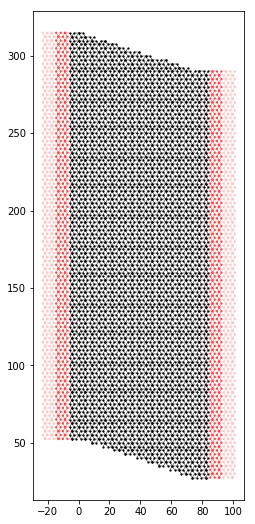

In [4]:
import matplotlib.pyplot as plt
import kwant
import numpy as np
import scipy
import scipy.ndimage
import scipy.linalg as la
from types import SimpleNamespace
%matplotlib inline

#designfile = '/users/tkm/kanilmaz/thesis/designfiles/hb_lower_part.png'
designfile = '/home/nefta/thesis/designfiles/qpc.png'
#designfile = '/home/nefta/thesis/designfiles/full_gate.png'
topgate = 1 - scipy.ndimage.imread(designfile, mode='L').T / 255
#topgate[0] = np.zeros(len(topgate[0]))
#topgate[1] = np.zeros(len(topgate[0]))
topgate_gauss = scipy.ndimage.gaussian_filter(topgate, 10)

scattering_region = np.fliplr(1 - scipy.ndimage.imread(
    '/home/nefta/thesis/designfiles/scatteringRegion.png', mode='L').T / 255)

delta = 1.0 
T = delta / 2
eta = 2.5 
gamma = 0.4
at = 5
a = 0.15
#a = 0.4
a_s = 0.0000001 * at # shift in one lattice for calculating and plotting current density

bilayer =  kwant.lattice.general([(at*np.sqrt(3)/2, at*1/2), (0, at*1)],
                                 [(0, 0.0), (at*1 / (2*np.sqrt(3)), at*1/2), 
                                  (-at*1/(2*np.sqrt(3)), at*1/2), (0, 0)], norbs=1)

a1, b1, a2, b2 = bilayer.sublattices
hoppings1 = (((0, 0), a1, b1), ((0, 1), a1, b1), ((1, 0), a1, b1)) 
hoppings2 = (((0, 0), a2, b2), ((0, -1), a2, b2), ((1, -1), a2, b2))

potential = scipy.interpolate.RectBivariateSpline(
    x=(a*np.arange(topgate_gauss.shape[0])),
    y=(a*np.arange(topgate_gauss.shape[1])),
    z=topgate_gauss,
    kx=1,
    ky=1,
)
def onsite(site, par):    
    topgate_potential = par.v_sg * potential(site.pos[0], site.pos[1]) 
    mu = (par.v_bg + topgate_potential) / 2 
    delta = - (topgate_potential - par.v_bg) / eta 
    disorder = par.v_dis * np.random.uniform(0, 1)
    # site.family in (a1, b1)
    #if (site.family == a1 or site.family == b1):
    #    return - mu - delta 
    #return -mu + delta
    if (site.family == a1 or site.family == b1):
        return - mu - delta + disorder
    return -mu + delta + disorder


def onsite_lead(site, par):     
    topgate_potential = 0
    mu = (par.v_bg + topgate_potential) / 2
    delta = - ( topgate_potential - par.v_bg) / eta
    if site.family == a1 or site.family == b1:
        return - mu - delta
    return -mu  + delta

def geomShape(pos):
    #x, y = pos
    if pos[0] < 0 or pos[1] < 0:
        return False
    try:
        # rather round()?
        return scattering_region[int(pos[0] / a), int(pos[1] / a)]
    except IndexError:
        return False

def hop_intra_layer(site1, site2, par): 
    xt, yt = site1.pos 
    xs, ys = site2.pos
    return -par.t * np.exp(-0.5j * np.pi * par.B  * (xt - xs) * (yt + ys))

def hop_inter_layer(site1, site2, par): 
    return -par.gamma1 

def hop_intra_layer_lead(site1, site2, par): 
    return -par.t 

def hop_inter_layer_lead(site1, site2, par): 
    return -par.gamma1 

def leadShape1(pos):
    y = pos[1]
    if y < 0:
        return False
    try:
        return scattering_region[0, int(y / a)]
    except IndexError:
        return False
    
def leadShape2(pos):
    y = pos[1]
    if y < 0:
        return False
    try:
        return scattering_region[-1, int(y / a)]
    except IndexError:
        return False
    
def make_system():
    #system = kwant.Builder(time_reversal=1)
    system = kwant.Builder()
    scat_width = scattering_region.shape[0]
    scat_length = scattering_region.shape[1]

    system[bilayer.shape(geomShape, (0.5*a*scat_width, 0.5*a*scat_length))] = onsite 
    system[[kwant.builder.HoppingKind(*hopping) for hopping in hoppings1]] = hop_intra_layer
    system[[kwant.builder.HoppingKind(*hopping) for hopping in hoppings2]] = hop_intra_layer
    system[kwant.builder.HoppingKind((0, 0), a1, b2) ] = hop_inter_layer    

    trans_sym_1 = kwant.TranslationalSymmetry(bilayer.vec((-2, 1)))
    lead_1 = kwant.Builder(trans_sym_1, time_reversal=1)
    lead_1[bilayer.shape(leadShape1, (0, 0.5*a*scat_length))] = onsite_lead
    lead_1[[kwant.builder.HoppingKind(*hopping) for hopping in hoppings1]] = hop_intra_layer_lead
    lead_1[[kwant.builder.HoppingKind(*hopping) for hopping in hoppings2]] = hop_intra_layer_lead
    lead_1[kwant.builder.HoppingKind((0, 0), a1, b2)] = hop_inter_layer_lead
    
    system.attach_lead(lead_1)

    trans_sym_2 = kwant.TranslationalSymmetry(bilayer.vec((2, -1))) #?
    lead_2 = kwant.Builder(trans_sym_2, time_reversal=1)
    lead_2[bilayer.shape(leadShape2, (0, 0.5*a*scat_length))] = onsite_lead
    lead_2[[kwant.builder.HoppingKind(*hopping) for hopping in hoppings1]] = hop_intra_layer_lead
    lead_2[[kwant.builder.HoppingKind(*hopping) for hopping in hoppings2]] = hop_intra_layer_lead
    lead_2[kwant.builder.HoppingKind((0, 0), a1, b2)] = hop_inter_layer_lead
    
    system.attach_lead(lead_2)
    system = system.finalized()
    #system.leads = [TRIInfiniteSystem(lead, trs) for lead in system.leads]#
    return(system)
par = SimpleNamespace(t=1, eta=2.5, gamma1=0.4, B=0.000, v_sg=-0.0, v_bg=0.5, v_dis=0.0)
system = make_system()
fig = kwant.plotter.plot(system, fig_size=(16, 9))#, site_color=family_colors, unit=3)
plt.show()

In [2]:
import numpy as np

In [3]:
t = 1
a = 1
mu = 1 #?
k_F = np.sqrt(mu / (t*a**2))
l_F = 2 * np.pi / k_F


In [6]:
def meanfree(U0):
    return (mu / U0)**2 * 6* l_F**3 / (np.pi**3 * a**2)

In [4]:
def uzero(l0):
    return mu * np.sqrt( 6 * l_F**3 / (np.pi**3 * a**2 * l0))

In [7]:
uzero(167)

0.53612046193052432